# Methane detection hackathon

It's a binary classification problem : does the image contain a plume of methane or not ?

In order to do that, a dataset containing images in `tif` format is provided along with metadata including :
* path
* date the satelite image was taken
* class (`plume` or `no_plume`)
* an ID identifying the location
* latitude and longitude coordinates locating the center of the plume (`lat`,`lon`)
* pixel coordinates locating the center of the plume in the image (`coord_x`,`coord_y`). Please be midnful that the axis origin (0,0) is at the top left corner of the image

The dataset contains two folders:
- `plume` : contains all images with plumes of methane.
- `no_plume` : contains all images with no plume of methane.


**All images have a resolution of 64x64 and they are in gray scale (2D-arrays).**

Images names are written in the following format `{date}_methane_mixing_ratio_id_{location id}.tif`

### Goal : detect methane leaks in the atmosphere based on satelite images

### 1. Install requirements

In [1]:
!pip install rasterio
!pip install pandas
!pip install opencv-python


  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/b7/8a/b2f7e1a434d56bf1d7570fc5941ace0847404e1032d7f1f0b8fed896568d/opencv_python-4.8.1.78-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 3.2 MB/s eta 0:00:00m eta 0:00:010:00:01


### 2. Import statements

In [2]:
import numpy as np
import pandas as pd
import rasterio
from rasterio.plot import show, show_hist
import warnings
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)
import matplotlib.pyplot as plt
import cv2


### 3. Read an image

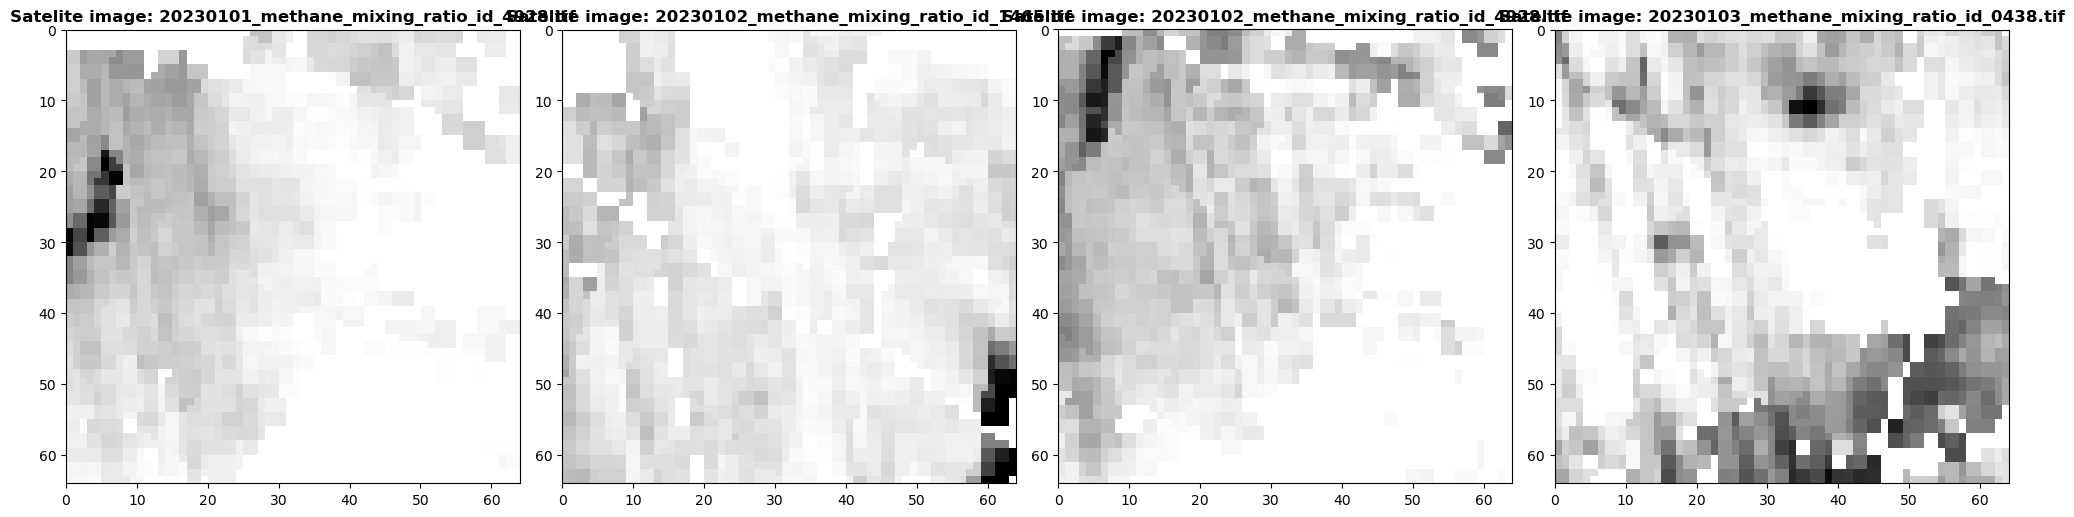

In [3]:
base_path = "train_data/images/plume/"

# List of files you want to open and visualize
files_to_open = [
    "20230101_methane_mixing_ratio_id_4928.tif",
    "20230102_methane_mixing_ratio_id_1465.tif",
    "20230102_methane_mixing_ratio_id_4928.tif",
    "20230103_methane_mixing_ratio_id_0438.tif"
]

# Plot setup
fig, axs = plt.subplots(1, len(files_to_open), figsize=(5 * len(files_to_open), 5))

# If only one subplot (i.e., len(files_to_open) is 1), axs is not an array. Convert it to an array for consistency.
if not isinstance(axs, (list, np.ndarray)):
    axs = [axs]

for i, filename in enumerate(files_to_open):
    path = base_path + filename
    
    try:
        example_image = rasterio.open(path)
        # This uses rasterio's plot.show method which can take an ax parameter
        rasterio.plot.show(example_image, ax=axs[i], cmap="Greys", title=f"Satelite image: {filename}")
    except rasterio.errors.RasterioIOError:
        print(f"File not found: {path}")

plt.tight_layout()
plt.show()


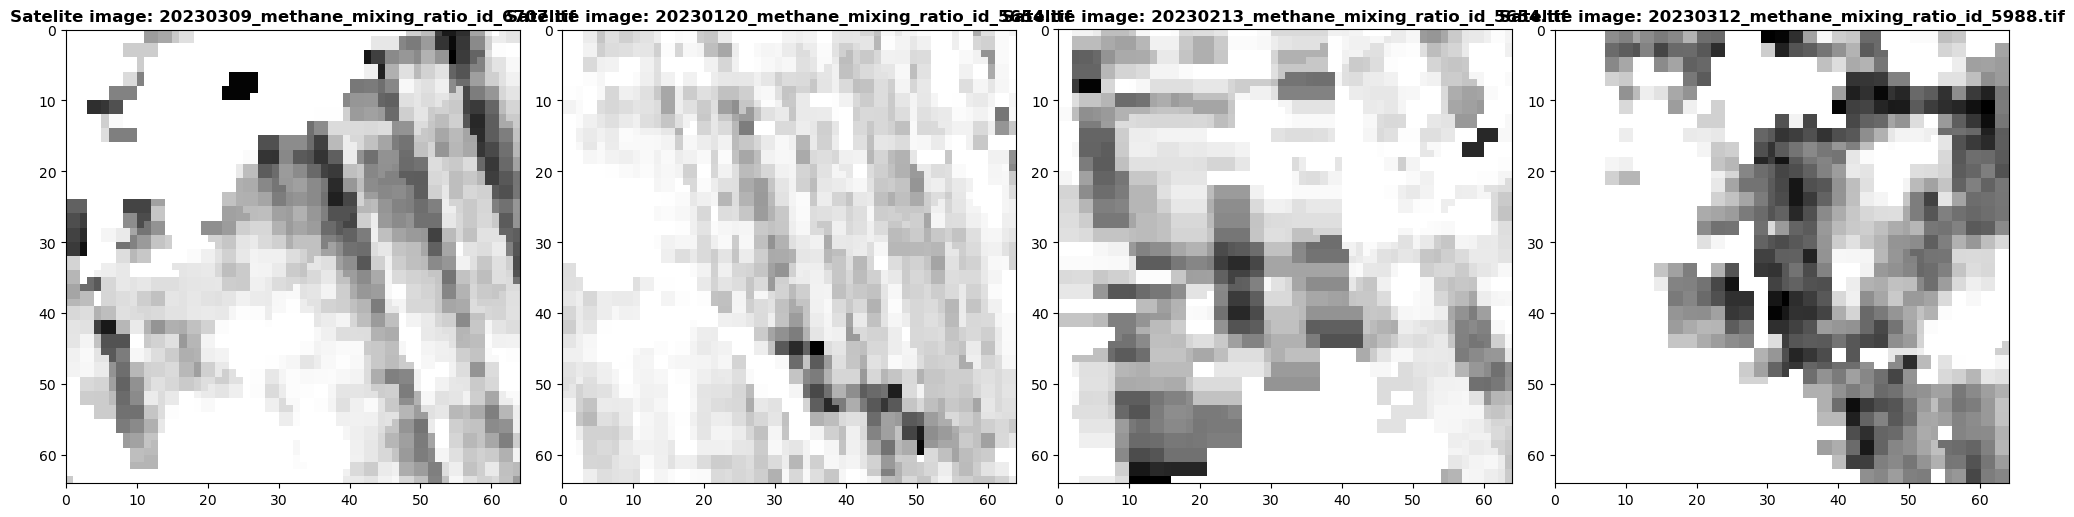

In [4]:
base_path = "train_data/images/no_plume/"

# List of files you want to open and visualize
files_to_open = [
"20230309_methane_mixing_ratio_id_6707.tif",
"20230120_methane_mixing_ratio_id_5654.tif",
"20230213_methane_mixing_ratio_id_5654.tif",
"20230312_methane_mixing_ratio_id_5988.tif"
]

# Plot setup
fig, axs = plt.subplots(1, len(files_to_open), figsize=(5 * len(files_to_open), 5))

# If only one subplot (i.e., len(files_to_open) is 1), axs is not an array. Convert it to an array for consistency.
if not isinstance(axs, (list, np.ndarray)):
    axs = [axs]

for i, filename in enumerate(files_to_open):
    path = base_path + filename
    
    try:
        example_image = rasterio.open(path)
        # This uses rasterio's plot.show method which can take an ax parameter
        rasterio.plot.show(example_image, ax=axs[i], cmap="Greys", title=f"Satelite image: {filename}")
    except rasterio.errors.RasterioIOError:
        print(f"File not found: {path}")

plt.tight_layout()
plt.show()


### 4. Distribution of pixel intensity in greyscale

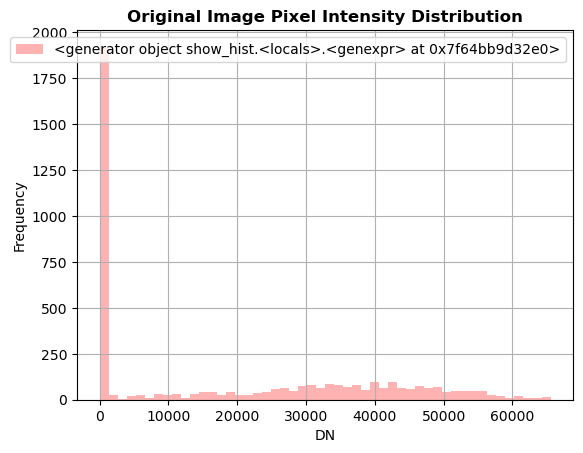

In [5]:
# Show the histogram for the original image
show_hist(example_image, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Original Image Pixel Intensity Distribution")

In [11]:
def apply_clahe(image: np.ndarray) -> np.ndarray:
    # Define the CLAHE object and apply
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(image)

    return enhanced

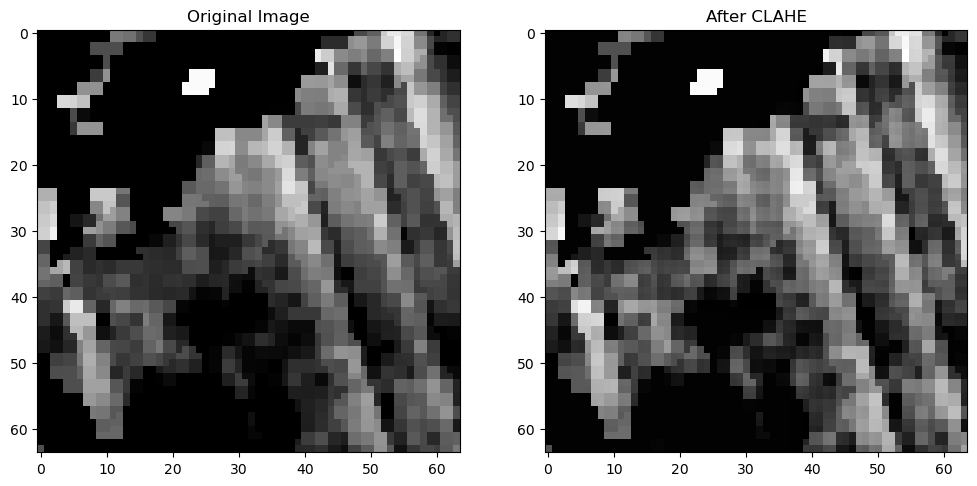

In [12]:
# Define the path to your image
sample_path = base_path + "20230309_methane_mixing_ratio_id_6707.tif"

# Open the image using rasterio
with rasterio.open(sample_path) as src:
    example_image = src.read(1)  # Assuming it's a single band image

# Apply CLAHE
enhanced_image = apply_clahe(example_image)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(example_image, cmap='gray')
ax1.set_title("Original Image")
ax2.imshow(enhanced_image, cmap='gray')
ax2.set_title("After CLAHE")

plt.show()

Images appear to be too pixalated for any quality augmentation methods (background removal or CLAHE) to work well. 

### 5. Metadata

- one pixel = 2.4 km x 2.4 km
- Lat Long = latitude and longitude of the estimated methane plume center
- coord_x coord_y = plume position in the image (origin = top / left) in pixels

In [8]:
metadata = pd.read_csv("train_data/metadata.csv")

In [9]:
metadata.head(5)

,date,id_coord,plume,set,lat,lon,coord_x,coord_y,path
0,20230223,id_6675,yes,train,31.528750,74.330625,24,47,images/plume/20230223_methane_mixing_ratio_id_...
1,20230103,id_2542,yes,train,35.538000,112.524000,42,37,images/plume/20230103_methane_mixing_ratio_id_...
2,20230301,id_6546,yes,train,21.060000,84.936667,58,15,images/plume/20230301_methane_mixing_ratio_id_...
3,20230225,id_6084,yes,train,26.756667,80.973333,28,62,images/plume/20230225_methane_mixing_ratio_id_...
4,20230105,id_2012,yes,train,34.800000,40.770000,59,44,images/plume/20230105_methane_mixing_ratio_id_...


In [10]:
metadata[metadata[["date","id_coord"]].duplicated()]

,date,id_coord,plume,set,lat,lon,coord_x,coord_y,path
16,20230216,id_4447,yes,train,53.954545,87.779091,39,8,images/plume/20230216_methane_mixing_ratio_id_...
99,20230330,id_8060,yes,train,37.260000,-82.192000,57,43,images/plume/20230330_methane_mixing_ratio_id_...
